In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table

import aos_utils
import zernike_utils

import seaborn as sns
sns.set_context("talk", font_scale=0.8)

os.environ["no_proxy"] += ",.consdb"

In [2]:
# Set dayObs to analyze
dayObs = 20251124 # Example dayObs, change as needed

seq_min = 5
seq_max = 14

In [3]:
raw_data = zernike_utils.getZernikesForDayObs(dayObs)
raw_data

,visit_id,band,day_obs,seq,z4,z5,z6,z7,z8,z9,...,z25,z26,z27,z28,detector,aos_fwhm,donut_blur_fwhm,rotation_angle,obs_start,zernikes
0,2025112400006,i_39,20251124,6,1.457643,3.770762,2.007679,-0.688147,-0.008317,-0.886373,...,-0.181001,-0.162382,-0.229295,0.127314,191,1.204150,1.989830,-0.080325,2025-11-25T00:25:29.508000,"[1.457642674446106, 3.7707617974577152, 2.0076..."
1,2025112400006,i_39,20251124,6,0.595800,0.485386,3.149560,0.082387,0.190743,1.102440,...,-0.021284,-0.188274,-0.069596,-0.087595,203,1.204150,1.989830,-0.080325,2025-11-25T00:25:29.508000,"[0.5957995653152466, 0.4853855155854914, 3.149..."
2,2025112400006,i_39,20251124,6,2.626554,1.206413,2.004548,-0.404948,0.606294,-0.003623,...,-0.099778,-0.115262,-0.099975,-0.125892,199,1.204150,1.989830,-0.080325,2025-11-25T00:25:29.508000,"[2.626554250717163, 1.2064126338772634, 2.0045..."
3,2025112400006,i_39,20251124,6,2.994356,0.631844,2.002468,0.592741,-1.236383,0.180239,...,0.016231,-0.161367,-0.289545,0.132755,195,1.204150,1.989830,-0.080325,2025-11-25T00:25:29.508000,"[2.9943559169769287, 0.6318444793249581, 2.002..."
4,2025112400007,i_39,20251124,7,3.259434,-0.358738,1.794484,0.544759,-1.093781,0.959886,...,0.036455,-0.179760,-0.188784,-0.141394,195,1.354492,2.128044,-0.080740,2025-11-25T00:26:05.924000,"[3.2594339847564697, -0.358737710004526, 1.794..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,2025112400394,u_24,20251124,394,-0.205072,0.240133,0.236728,-0.127051,-0.116610,-0.048729,...,0.023221,0.025845,0.021383,-0.026965,203,0.407380,0.884837,75.082564,2025-11-25T07:59:06.013000,"[-0.20507162809371948, 0.24013307291444724, 0...."
1524,2025112400395,u_24,20251124,395,-0.257486,0.243798,-0.037161,0.282717,-0.053512,0.008416,...,0.033992,0.016649,0.010949,-0.069543,195,0.542034,0.972933,-8.822588,2025-11-25T08:00:21.308000,"[-0.25748613476753235, 0.24379841918229875, -0..."
1525,2025112400395,u_24,20251124,395,-0.420966,-0.648054,0.246710,0.730337,0.334570,-0.134781,...,0.004464,-0.039023,0.011291,-0.082824,191,0.542034,0.972933,-8.822588,2025-11-25T08:00:21.308000,"[-0.4209658205509186, -0.6480542588429715, 0.2..."
1526,2025112400395,u_24,20251124,395,0.105940,0.367948,-0.117989,0.775189,0.113527,-0.080125,...,0.056424,0.052130,0.083646,-0.034349,199,0.542034,0.972933,-8.822588,2025-11-25T08:00:21.308000,"[0.10594023019075394, 0.367947712470006, -0.11..."


In [4]:
def process_visit(visit_df: pd.DataFrame, aos_utils) -> tuple[dict, np.ndarray] | None:
    """
    Process a single visit to estimate telescope state and predict wavefront.
    
    Parameters
    ----------
    visit_df : `pandas.DataFrame`
        DataFrame containing data for a single visit.
    aos_utils : module
        The aos_utils module (passed in to avoid circular import issues if imported at top level).
        
    Returns
    -------
    result : `tuple` or None
        (res_dict, dofState) where res_dict contains per-detector Zernikes and 
        dofState is the estimated state array. Returns None if failed.
    """
    wavefrontResults = zernike_utils.make_wavefront_results(visit_df)
    
    filterName = visit_df["band"].iloc[0]
    # I DON'T KNOW WHAT IS THIS ANGLE
    # IT SHOULD COME FROM zernikeTable.meta["rotTelPos"]
    # BUT WE DON'T HAVE zernikeTable HERE
    rotTelPos = wavefrontResults["rot_tel_rad"].iloc[0]

    rotMat = np.array(
        [[np.cos(rotTelPos), np.sin(rotTelPos)], [-np.sin(rotTelPos), np.cos(rotTelPos)]]
    )
    
    # Mock ZernikeTable for estimateTelescopeState
    zernikeTable = Table()
    zernikeTable.meta["nollIndices"] = np.arange(4, 29)
    zernikeTable.meta["rotTelPos"] = rotTelPos
    
    # Estimate Telescope State (x_k)
    dofState = aos_utils.estimateTelescopeState(
        zernikeTable, wavefrontResults, filterName
    )
    
    # Predict Wavefront (y_hat)
    predictions = zernike_utils.predictWavefrontFromDofs(
        dofState, wavefrontResults, rotMat
    )
    
    # Store Results
    res_dict = {
        "visit_id": visit_df["visit_id"].iloc[0],
        "seq_num": visit_df["seq"].iloc[0],
        "day_obs": visit_df["day_obs"].iloc[0]
    }
    
    zks_pred = predictions["zksEstimated"]
    zks_meas = predictions["zksMeasured"] # This is padded deviation
    dets = predictions["detector"]
    
    for i, det in enumerate(dets):
        for z_idx in range(4, 29):
            res_dict[f"Z{z_idx}_meas_{det}"] = zks_meas[i, z_idx]
            res_dict[f"Z{z_idx}_pred_{det}"] = zks_pred[i, z_idx]
            
    return res_dict, dofState

In [5]:
# 2. Process Data: Estimate State and Predict Wavefront
results_list = []
mask = (raw_data["seq"]>=seq_min)&(raw_data["seq"]<=seq_max)

if not raw_data.empty:
    # Group by visit
    visits = raw_data["visit_id"][mask].unique()
    
    print(f"Processing {len(visits)} visits...")

    # Store results indexed by visit_id for easier access during forward prediction
    visit_results = {}
    visit_states = {}

    for i, visit_id in enumerate(visits):
        visit_df = raw_data[raw_data["visit_id"] == visit_id]
        
        # Use helper function to process visit
        # Now returns (res_dict, dofState)
        result = process_visit(visit_df, aos_utils)
        
        if result:
            res_dict, dofState = result
            visit_results[visit_id] = res_dict
            visit_states[visit_id] = dofState
    
    final_results = []
    for visit_id in visits:
        res = visit_results[visit_id].copy()
        final_results.append(res)
    results_df = pd.DataFrame(final_results)
    print(f"Processed {len(results_df)} visits.")

Processing 9 visits...


In [22]:
# 3. Plotting
def plot_zernike(ax, results_df, z_idx, dets, colors, markers):
    """
    Plot one Zernike coefficient (Measured, Predicted, and Forward Predicted) into a given axes.
    """
    if results_df.empty:
        return
        
    seq = results_df["seq_num"].astype(int)

    for j, det in enumerate(dets):
        if f"Z{z_idx}_meas_{det}" not in results_df.columns:
            continue
            
        color = colors.get(det, 'black')
        marker = markers[j % len(markers)]

        # Measured (Solid Line)
        ax.plot(
            seq,
            results_df[f"Z{z_idx}_meas_{det}"],
            marker=marker,
            ls='-',
            markerfacecolor='none',
            color = color,
            markeredgecolor=color,
            label=f"{det} Meas"
        )

        # Predicted (Dashed Line) - Current State Fit
        ax.plot(
            seq,
            results_df[f"Z{z_idx}_pred_{det}"],
            marker=marker,
            ls='',
            color=color,
            label=f"{det} Pred"
        )

    ax.set_title(f"Z{z_idx}")
    ax.set_ylabel("Coefficient (microns)")
    ax.grid(True, alpha=0.3)


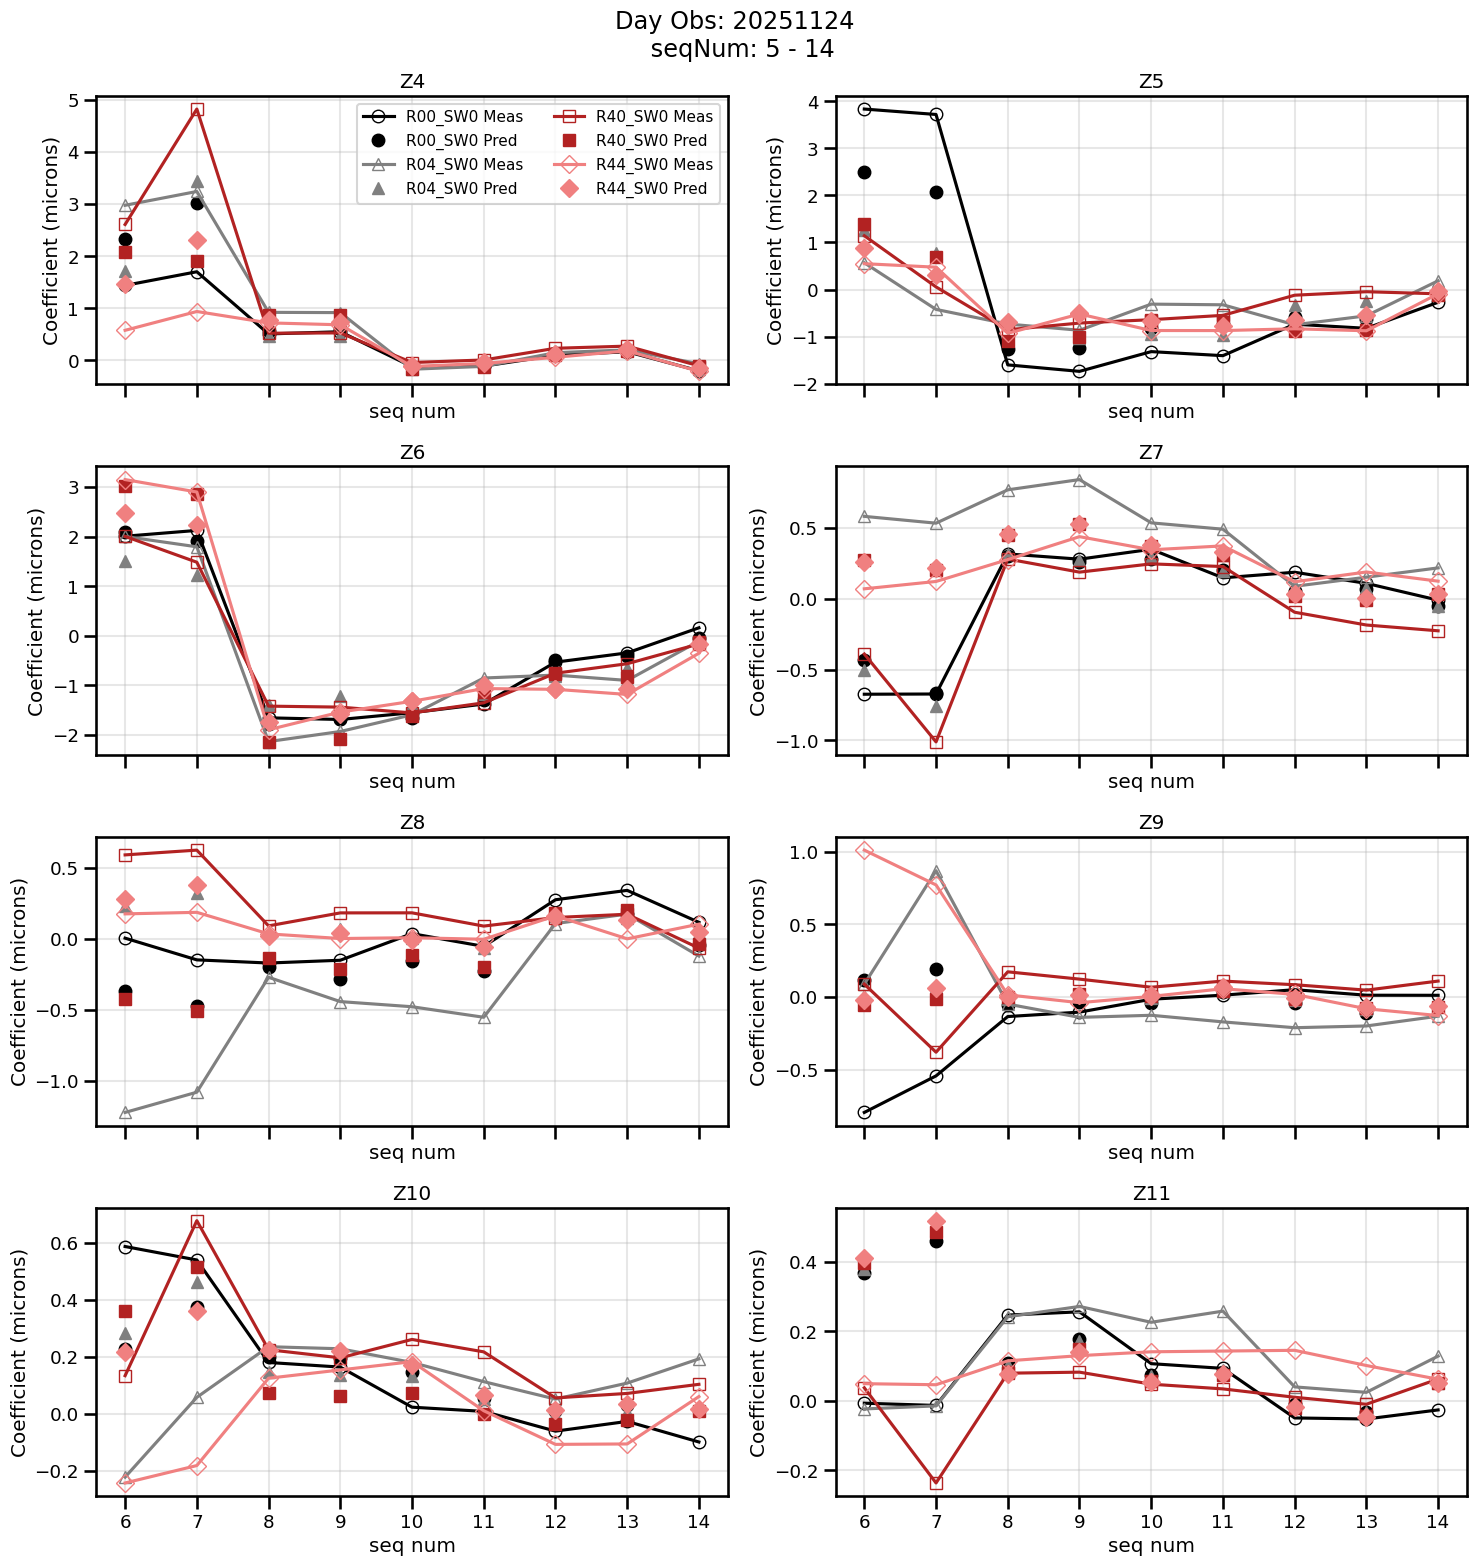

In [31]:
# Define detectors and styles
detectors = ["R00_SW0", "R04_SW0", "R40_SW0", "R44_SW0"]
colors = {
    "R00_SW0": "k",
    "R04_SW0": "grey",
    "R40_SW0": "firebrick",
    "R44_SW0": "lightcoral"
}
markers = ["o", "^", "s", "D"]


# Create plots for Z4 to Z15 (example range)
z_indices = range(4, 12)
num_plots = len(z_indices)
cols = 2
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharex=True)
axes = axes.flatten()

for i, z_idx in enumerate(z_indices):
    plot_zernike(axes[i], results_df, z_idx, detectors, colors, markers)
    if i==0:
        axes[i].legend(ncol=2, fontsize=11)

fig.suptitle(f'Day Obs: {dayObs} \n seqNum: {seq_min} - {seq_max}')
plt.tight_layout()
plt.savefig(f'../figures/zernike_four_corner_{dayObs}',dpi=120)